In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats 

## White noise (Ruido Blanco)

Vamos a examinar un proceso estocástico sencillo conocido como ruido blanco. El ruido blanco puede generarse a partir de varias distribuciones de probabilidad. En este caso, vamos a tomar muestras de una distribución gaussiana univariada.

![Texto Alternativo](../../../Image/WN.png)

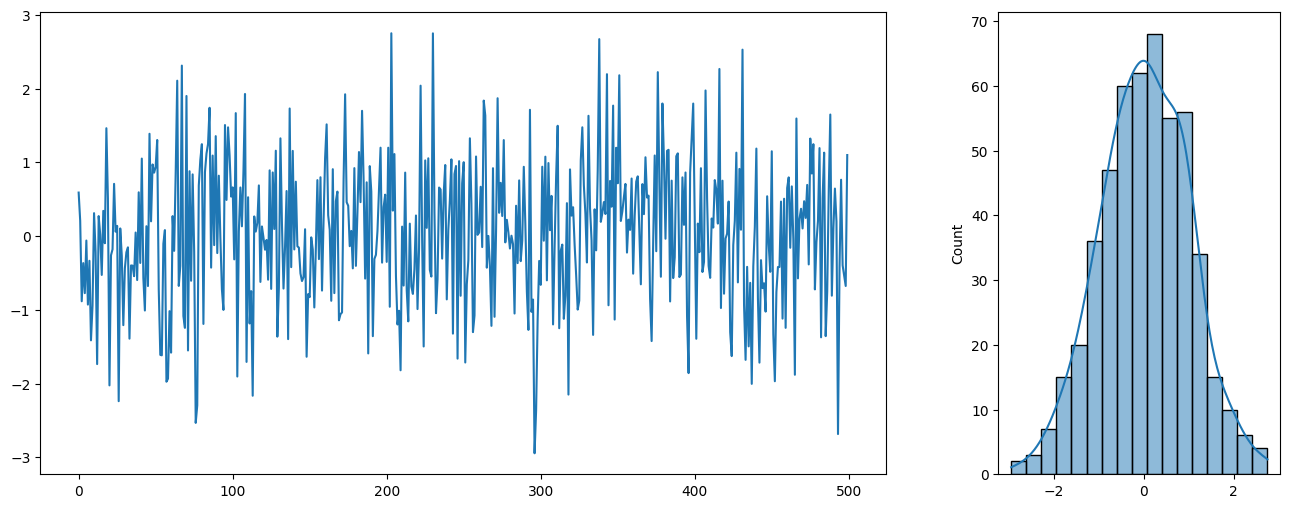

In [102]:
n = 500
fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
eps = np.random.normal(size=n)
ax[0].plot(eps)
sns.histplot(eps, ax=ax[1], kde=True)
plt.show()


## White noise signal

Este proceso es completamente aleatorio, aunque podemos inferir algunas propiedades de esta serie. Al hacer un gráfico de la distribución, podemos suponer que estas variables provienen de una única distribución normal con media cero y varianza unitaria. Nuestra mejor estimación para el valor de cualquier nueva variable sería el valor 0. No existe un modelo mejor para este proceso, ya que cada nueva extracción de la distribución es completamente aleatoria e independiente de los valores anteriores. El ruido blanco es algo que esperamos ver en los residuos después de haber definido un modelo. Si los residuos siguen un patrón de ruido blanco, podemos estar seguros de que hemos capturado toda la variabilidad posible.

## MA process (Moving average)

Un proceso de media móvil (MA) se basa en este ruido blanco. Se define como un promedio ponderado de los valores anteriores de ruido blanco. 

![Texto Alternativo](../../../Image/MA.png)

Donde θ son los parámetros del proceso y q es el orden del proceso. Con orden nos referimos a cuántos pasos de tiempo q deberíamos incluir en el promedio ponderado.

Vamos a simular un proceso de MA. Para cada paso de tiempo t tomamos los valores ϵ hasta q pasos atrás. Primero, creamos una función que dado un arreglo unidimensional crea un arreglo bidimensional con filas que miran q índices atrás.

In [103]:
def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

En la función anterior creamos esa matriz 2D. También truncamos tanto el arreglo de entrada como el de salida para que todas las filas tengan valores rezagados. Si llamamos a esta función con un arreglo que va de 0 a 10 y un orden de 3, obtenemos el siguiente resultado:

In [104]:
lag_view(np.arange(10), 3)[0]

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

Ahora podemos fácilmente echar un vistazo a diferentes rezagos en el tiempo. Vamos a simular tres procesos MA diferentes con órdenes q = 1, q = 6, q = 11:

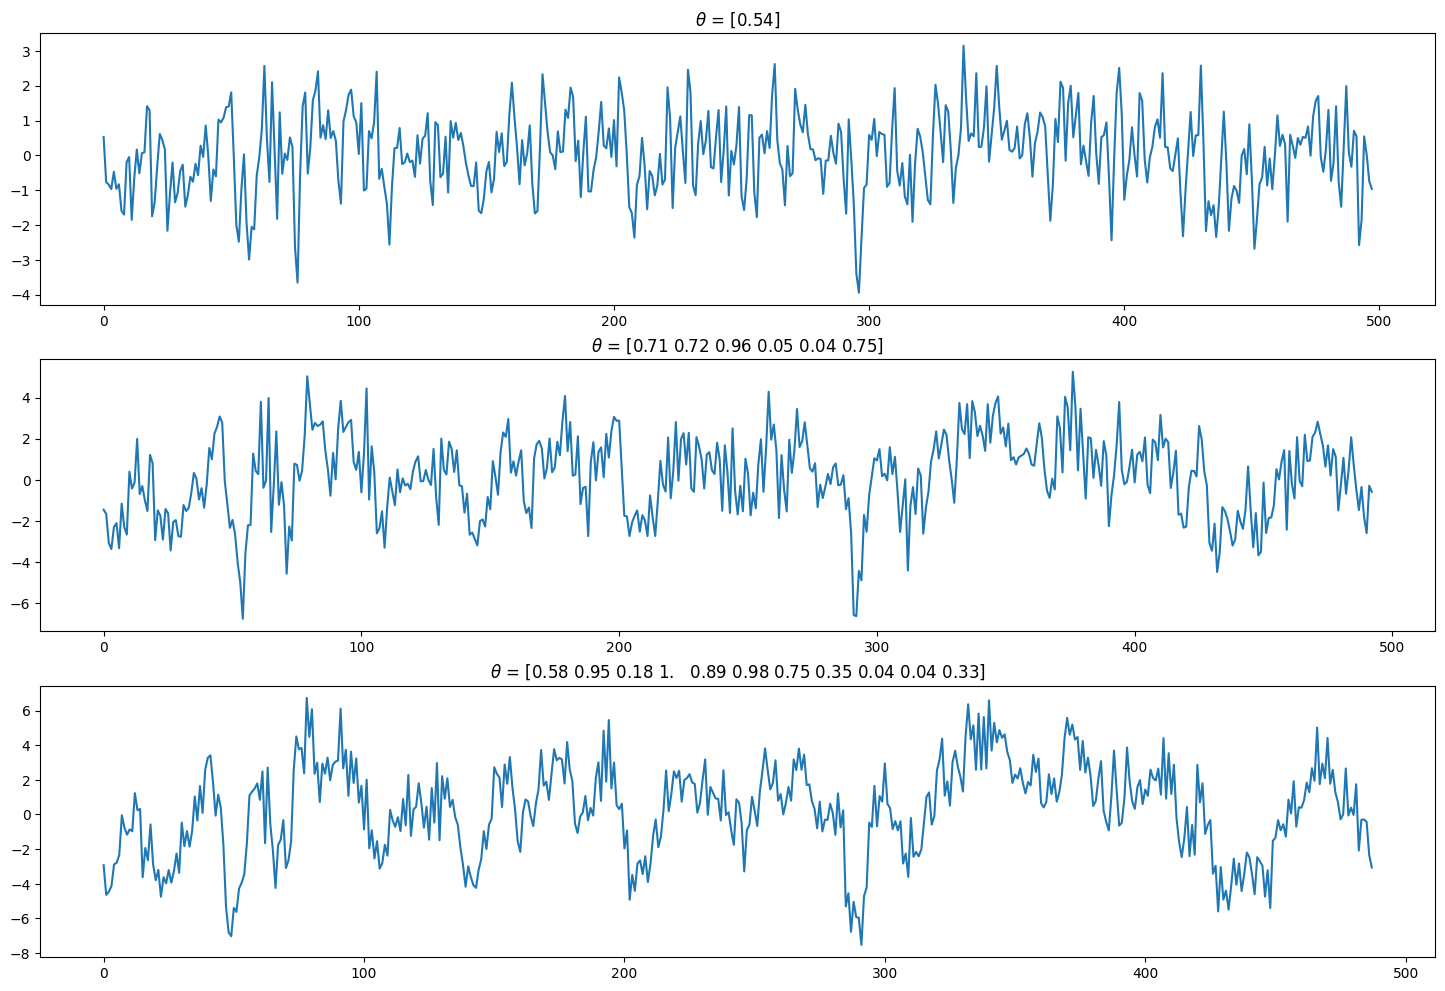

In [105]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

fig = plt.figure(figsize=(18, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    theta = np.random.uniform(0, 1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\theta$ = {theta.round(2)}')
    plt.plot(ma_process(eps, theta))

## MA processes from different orders

Es importante destacar que he elegido valores positivos para θ, lo cual no es necesario. Un proceso MA puede tener tanto valores positivos como negativos para θ. En los gráficos anteriores se puede observar que a medida que aumenta el orden de MA(q), los valores están menos correlacionados con los valores previos. De hecho, debido a que el proceso es un promedio ponderado de los valores ϵ hasta el rezago q, la correlación disminuye después de este rezago. Basándonos en esta propiedad, podemos hacer una estimación informada sobre el orden de un proceso MA(q). Esto es muy útil porque suele ser difícil inferir el orden simplemente observando los gráficos directamente.

## Autocorrelation

Cuando un valor Xt está correlacionado con un valor previo Xt-1, esto se llama autocorrelación. La función de autocorrelación se define como:

![Texto Alternativo](../../../Image/ACF.png)

Numéricamente, podemos aproximar la función de autocorrelación calculando la correlación entre diferentes arreglos, específicamente entre Xt y el arreglo Xt-1. Para hacer esto, necesitamos truncar ambos arreglos por k elementos para mantener una longitud igual.

In [106]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf(x, lag=40):
    """
    Determine autocorrelation factors.
    :param x: (array) Time series.
    :param lag: (int) Number of lags.
    """
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

lag = 40
# Create an ma(1) and an ma(2) process.
ma_1 = ma_process(eps, [1])
ma_2 = ma_process(eps, [0.2, -0.3, 0.8])

Arriba hemos creado un proceso MA(1) y un proceso MA(2) con diferentes pesos θ. Los pesos para los modelos son:

MA(1): [1]
MA(2): [0.2, -0.3, 0.8]

A continuación, aplicamos la función de autocorrelación (ACF) a ambas series y graficamos el resultado de ambas funciones aplicadas. También hemos definido una función auxiliar llamada bartletts_formula, que utilizamos como una hipótesis nula para determinar si los coeficientes de correlación que hemos encontrado son significativos y no simplemente un accidente estadístico. Con esta función, determinamos un intervalo de confianza (CI).

![Texto Alternativo](../../../Image/CI.png)


donde, z 1−α/2 es la función cuantil de la distribución normal estándar. Las funciones cuantil son el inverso de la función de distribución acumulativa y se pueden llamar con scipy.stats.norm.ppf. Cualquier valor fuera de este intervalo de confianza (marcado en naranja en el gráfico) es estadísticamente significativo.

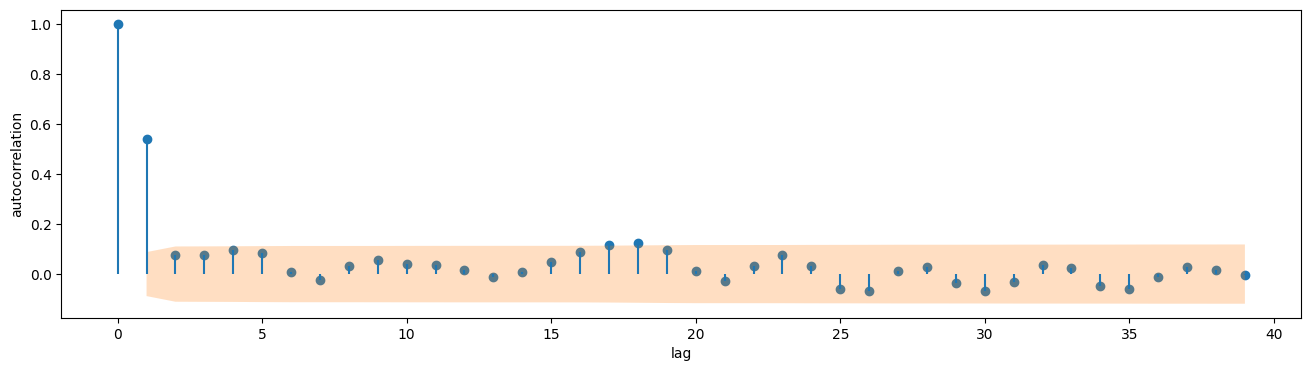

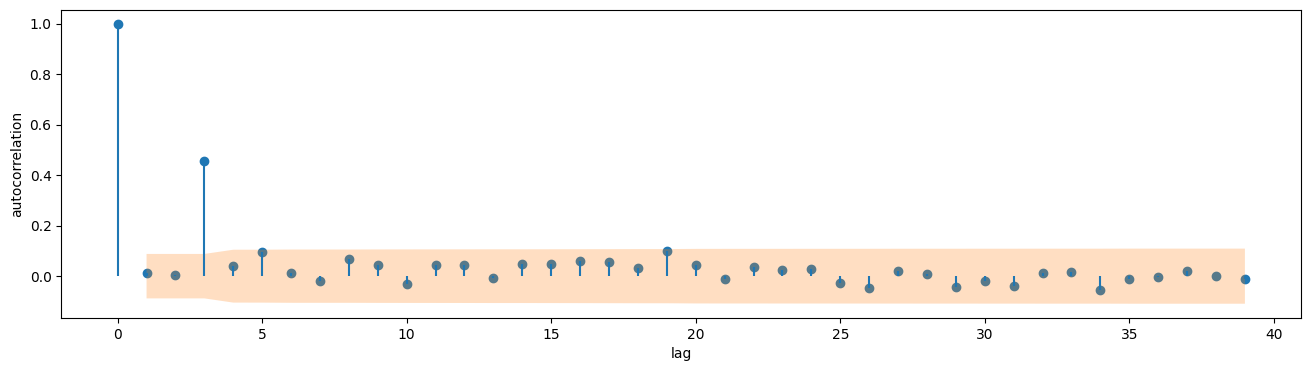

In [107]:
def bartletts_formula(acf_array, n):
    """
    Computes the Standard Error of an acf with Bartlet's formula
    Read more at: https://en.wikipedia.org/wiki/Correlogram
    :param acf_array: (array) Containing autocorrelation factors
    :param n: (int) Length of original time series sequence.
    """
    # The first value has autocorrelation with it self. So that values is skipped
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n )
    return se


def plot_acf(x, alpha=0.05, lag=40):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    acf_val = acf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

for array in [ma_1, ma_2]:
    plot_acf(array)

Como mencionamos anteriormente, estos gráficos nos ayudan a inferir el orden del modelo MA(q). En ambos gráficos podemos observar un corte claro en los valores significativos. Ambos gráficos comienzan con una autocorrelación de 1, que es la autocorrelación en el rezago 0. El segundo valor es la autocorrelación en el rezago 1, el tercero en el rezago 2, etc. En el primer gráfico, el corte es después de 1 rezago y en el segundo gráfico el corte es en el rezago 3. ¡Así que en nuestro conjunto de datos artificial podemos determinar el orden de diferentes modelos MA(q) al observar el gráfico de la función de autocorrelación (ACF)!

## AR process (Auto Regressive)

En la sección anterior hemos visto y simulado un proceso MA, y hemos descrito la definición de autocorrelación para inferir el orden de un proceso puramente MA. Ahora vamos a simular otra serie llamada proceso Auto Regresivo (AR). Nuevamente, vamos a inferir visualmente el orden del proceso. Esta vez lo haremos utilizando la Función de Autocorrelación Parcial (PACF).

Un proceso AR(p) se define como:

![Texto Alternativo](../../../Image/AR.png)

Ahora, ϕ son los parámetros del proceso y p es el orden del proceso. Mientras que MA(q) es un promedio ponderado de los términos de error (ruido blanco), AR(p) es un promedio ponderado de los valores previos de la serie Xt-p. Es importante notar que este proceso también incluye un término de ruido blanco, lo que hace que sea una serie estocástica.

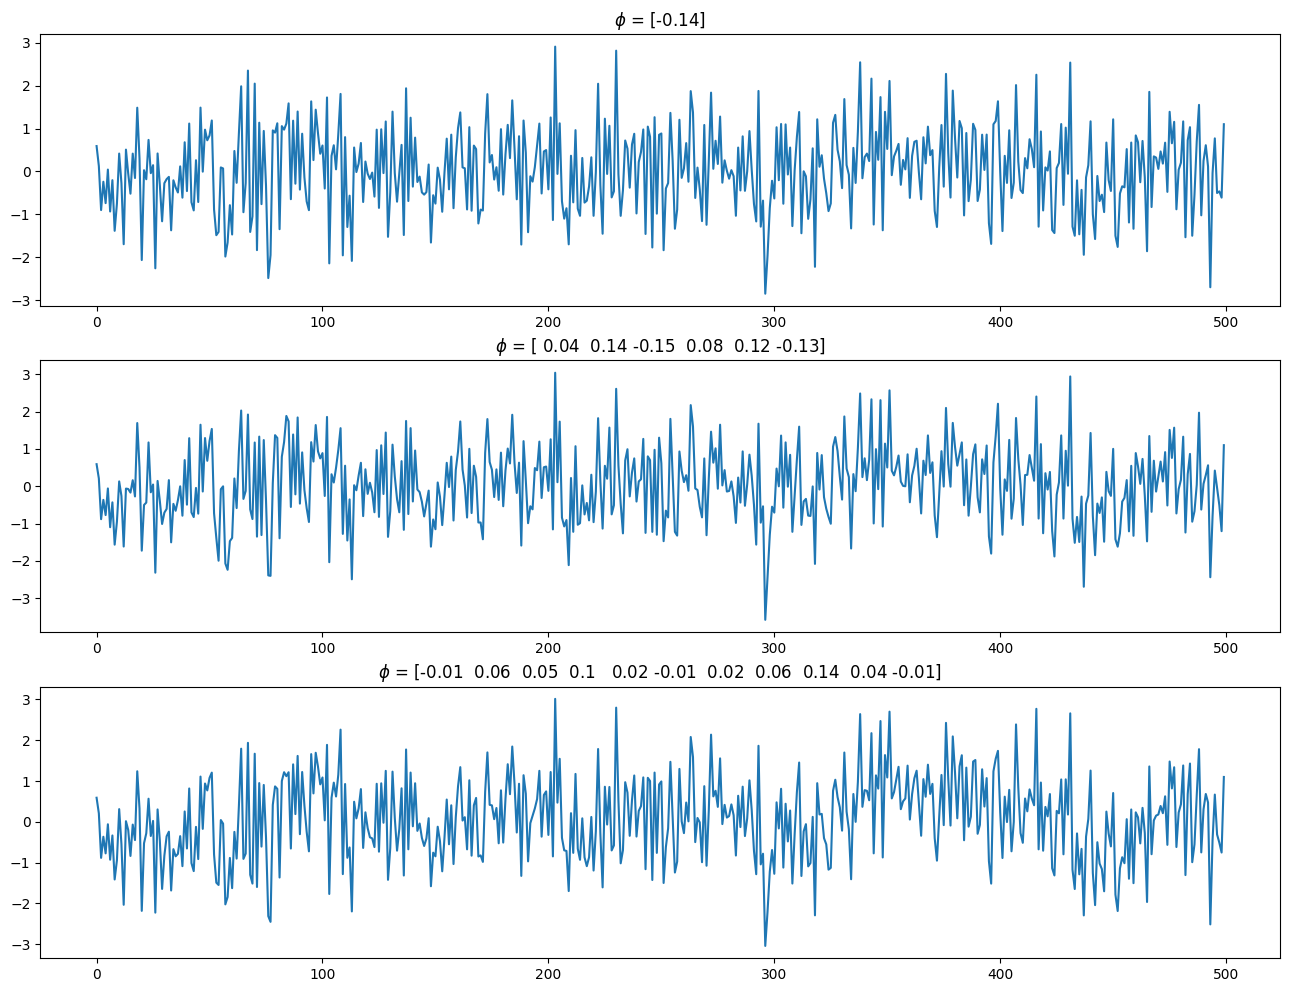

In [108]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1] 
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

fig = plt.figure(figsize=(16, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    phi = np.random.normal(0, 0.1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\phi$ = {phi.round(2)}')
    plt.plot(ar_process(eps, phi))

## AR processes from different orders

A continuación, creamos tres nuevos procesos AR(p) y graficamos la función de autocorrelación (ACF) de estas series.

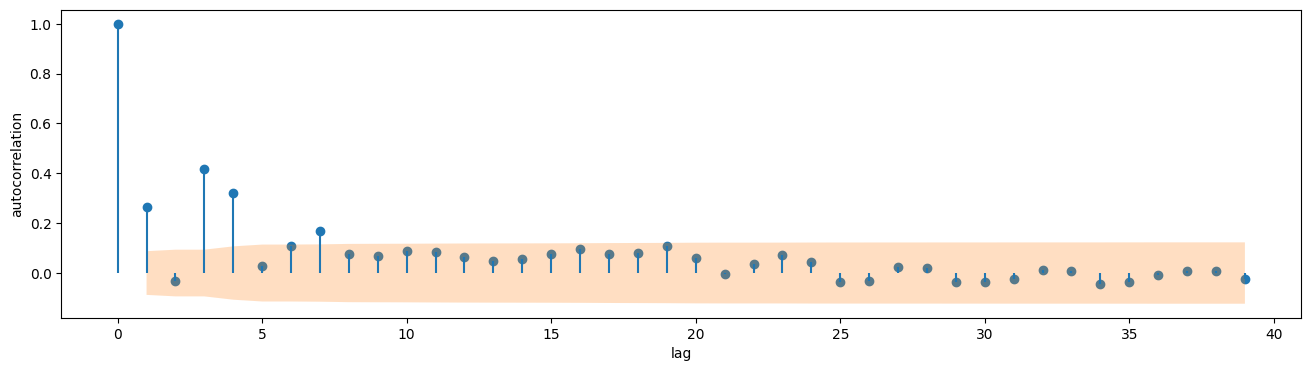

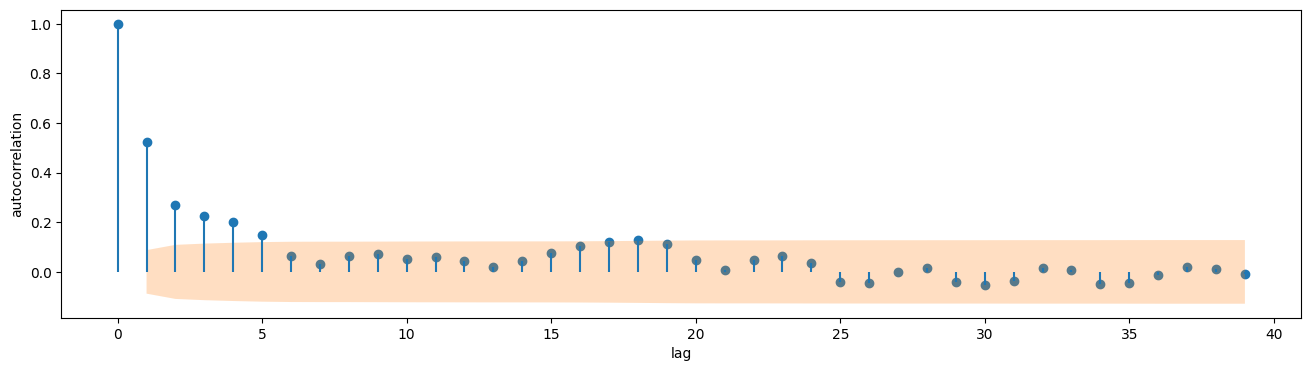

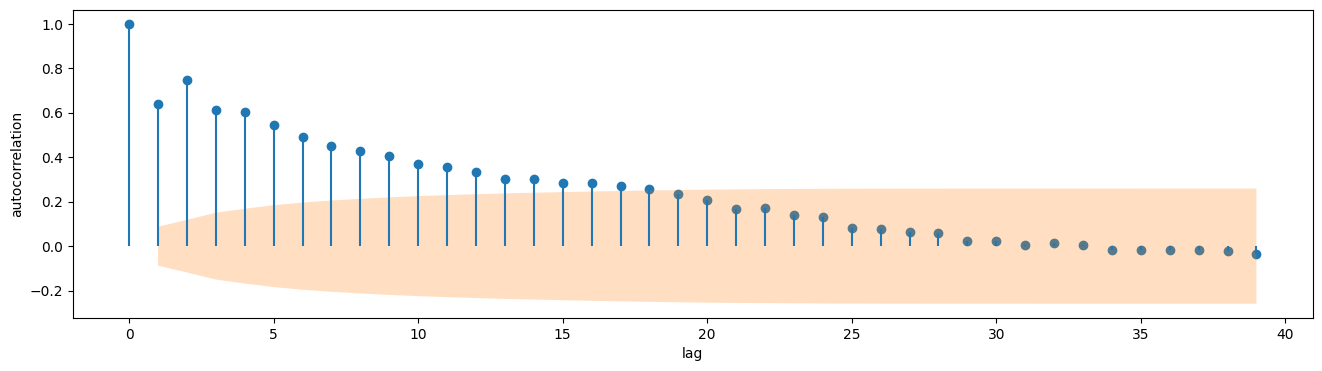

In [109]:
plot_acf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_acf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_acf(ar_process(eps, [0.2, 0.5, 0.1]))

## The ACF computed from 3 different AR series

Al analizar estos gráficos, podemos observar que el gráfico de la función de autocorrelación (ACF) de estos procesos AR no necesariamente se corta después del rezago  p. En el primer gráfico, vemos que los valores de la ACF disminuyen gradualmente hacia cero, el segundo gráfico muestra un corte significativo en el rezago p y el tercer gráfico tiene una autocorrelación que disminuye linealmente hasta el rezago 14. Para el proceso AR(p), la ACF claramente no es decisiva para determinar el orden del proceso. De hecho, para los procesos AR podemos utilizar otra función para inferir el orden del proceso.

## Partial autocorrelation

La función de autocorrelación parcial muestra la autocorrelación entre el valor Xt y Xt-k después de explicar la correlación entre Xt con los valores intermedios Xt-1,..., Xt-k+1. A continuación, vamos a través de los pasos necesarios para determinar la autocrrelación parcial. 

La correlación parcial entre Xt y Xt-k puede determinarse entrenando dos modelos lineales.

Deja que Xt y Xt-k sean determinados por un Modelo Lineal optimizado en Xt-1,..., Xt-(k-1) y parametrizado por α y β.

![Texto Alternativo](../../../Image/Linear.png)

La correlación parcial se define entonces como el coeficiente de Pearson de los residuos de ambos valores predichos Xt y Xt-k.

![Texto Alternativo](../../../Image/PCAF.png)

## Sección: Modelo Lineal

Anteriormente utilizamos un modelo lineal para definir la Función de Autocorrelación Parcial (PACF). Más adelante en esta publicación, también vamos a entrenar un modelo ARIMA, que es lineal. Entonces, rápidamente definamos un modelo de regresión lineal.

La regresión lineal se define como:

![Texto Alternativo](../../../Image/ML.png)

donde los parámetros se pueden encontrar mediante mínimos cuadrados ordinarios:

![Texto Alternativo](../../../Image/ML1.png)




In [110]:
def least_squares(x, y):
    return np.linalg.inv((x.T @ x)) @ (x.T @ y)

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None
    
    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x
    
    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta
        
    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

Habiendo definido anteriormente una clase elegante de scikit-learn que puede realizar regresión lineal, entrenamos aplicando el método fit. Si también queremos entrenar el modelo con una intersección, agregamos unos a la matriz de características. Esto resultará en un desplazamiento constante al aplicar βX.

Con el breve apartado en su lugar, finalmente podemos definir la función de autocorrelación parcial y graficar los resultados.

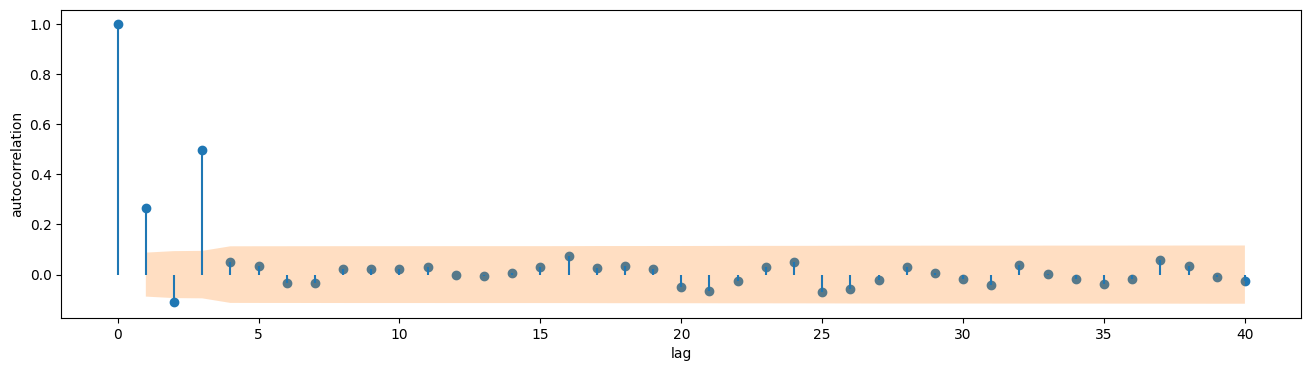

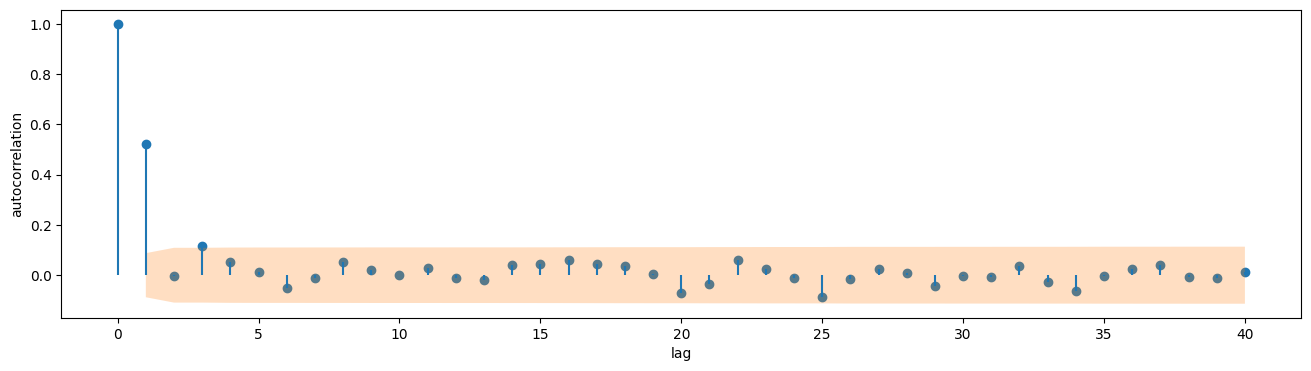

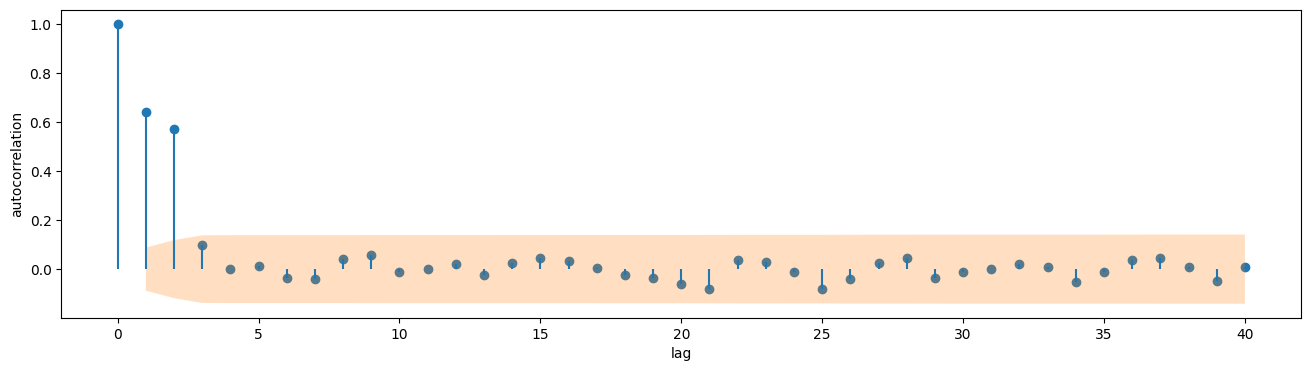

In [111]:
def pacf(x, lag=40):
    """
    Partial autocorrelation function.
    
    pacf results in:
        [1, acf_lag_1, pacf_lag_2, pacf_lag_3]
    :param x: (array)
    :param lag: (int)
    """
    y = []
    
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag + 2):
        backshifted = lag_view(x, i)[0]

        xt = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

        xt_k = backshifted[:, -1]
        xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
    return np.array([1, acf(x, 2)[1]] +  y)

def plot_pacf(x, alpha=0.05, lag=40, title=None):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    pacf_val = pacf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

plot_pacf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_pacf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_pacf(ar_process(eps, [0.2, 0.5, 0.1]))

## The PACF for 3 AR processes.

Ahora observamos un corte significativo en el rezago 3 para los 3 procesos. Por lo tanto, podemos inferir el orden de los procesos. La relación entre los procesos AR y MA y las gráficas de ACF y PACF son importantes para inferir el orden de una serie particular.

![Texto Alternativo](../../../Image/pq.png)

En la tabla anterior mostramos esta relación. El proceso ARMA(p,q) también está incluido en esta tabla. Aún no hemos mencionado este proceso, pero en realidad es simplemente una combinación de una serie AR(p) y una serie MA(q).

Antes de adentrarnos en esta combinación de procesos AR y MA, repasaremos una última definición, que es la Integración (la I en ARIMA). Con eso, habremos cubierto todas las partes de un modelo ARIMA.

## Stationary

Un modelo ARMA requiere que los datos sean estacionarios, algo que no necesita un modelo ARIMA. Una serie estacionaria tiene una media constante y una varianza constante a lo largo del tiempo. Para el ruido blanco y los procesos AR y MA que hemos definido anteriormente, este requisito se cumple, pero muchas veces los datos del mundo real no son estacionarios. Los modelos ARIMA pueden trabajar con datos que no son estacionarios, pero que tienen una tendencia. Sin embargo, los modelos ARIMA no funcionan bien con series temporales que también presentan patrones recurrentes (estacionalidad).

Cuando los datos muestran una tendencia, podemos eliminarla mediante la diferenciación entre los pasos temporales Xt y Xt-1. Podemos aplicar la diferenciación n veces hasta que los datos sean estacionarios. Podemos probar la estacionariedad con una prueba de Dickey-Fuller. Cómo se realiza esta prueba está más allá del alcance de esta publicación.

Podemos diferenciar una serie temporal mediante: 

![Texto Alternativo](../../../Image/diferenciacion.png)

y simplemente deshacer esto tomando la suma.

![Texto Alternativo](../../../Image/diferenciacion1.png)

Podemos implementar esto fácilmente con dos funciones recurrentes:

In [112]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)

## ARIMA

Finalmente hemos discutido (e implementado) todos los temas que necesitamos para definir un modelo ARIMA. Este modelo tiene hiperparámetros p, q y d.

p es el orden del modelo AR (Auto Regresivo).
q es el orden del modelo MA (Media Móvil).
d es el orden de diferenciación (cuántas veces diferenciamos los datos).

La combinación ARMA y ARIMA se define como:

![Texto Alternativo](../../../Image/ARIMA.png)

Vemos que el modelo se basa en términos de ruido blanco, los cuales no conocemos ya que provienen de un proceso completamente aleatorio. Por lo tanto, usaremos un truco para obtener términos de ruido blanco cuasi-aleatorios. Primero, entrenaremos el modelo AR(p) y luego tomaremos los residuos como términos ϵ. Ten en cuenta que esto conducirá a una estimación de un modelo ARIMA. Podríamos mejorar la estimación de los términos de error ϵ mediante el entrenamiento iterativo del modelo ARIMA mientras actualizamos los residuos en cada iteración. Por ahora, aceptaremos el método de cuasi-ruido blanco.

Con estos términos de ruido blanco, podemos comenzar a modelar el modelo completo ARIMA(q, d, p).

A continuación, hemos definido la clase ARIMA que hereda de LinearModel. Debido a esta herencia, podemos llamar a los métodos fit y predict del padre utilizando la función super.

In [113]:
class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

Como acabo de mencionar, la clase ARIMA hereda de LinearModel, por lo que primero inicializamos el padre y pasamos el booleano True para ajustar también una intersección en el modelo. En el método prepare_features (nota que este no tiene un prefijo _ y por lo tanto difiere del método del padre), creamos las características para el modelo de regresión lineal. Las características incluyen los pasos de tiempo rezagados 
Xt−k con orden q, que es la parte AR del modelo, y los términos de error rezagados ϵt−k, que es la parte MA del modelo. En este método también entrenamos primero un modelo AR, de modo que podamos usar los residuos de ese modelo como términos de error. Observa que añadimos ceros al principio de ϵ y X, donde n es igual al orden q y p respectivamente. Esto se hace porque no hay valores 
ϵt−q y Xt−p en el tiempo t = 0. Además, implementamos algunos métodos inspirados en las convenciones de nomenclatura de scikit-learn, como los métodos fit_predict, fit y predict.

Discutiremos el método forecast más adelante. Primero vamos a verificar cómo se comporta un objeto de esta clase comparándolo con la implementación de statsmodels. También utilizaremos datos de prueba provenientes de esta biblioteca.

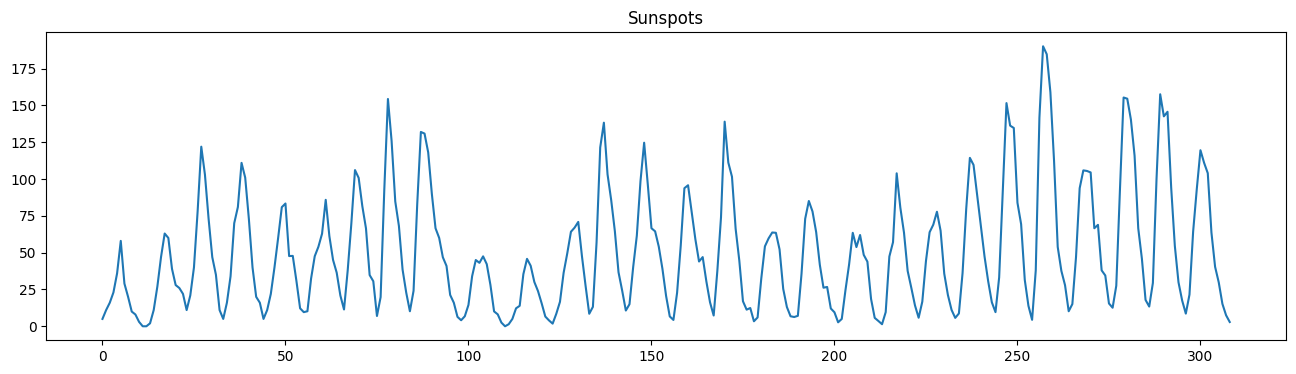

In [114]:
data = sm.datasets.sunspots.load_pandas().data
x = data['SUNACTIVITY'].values.squeeze()

plt.figure(figsize=(16,4))
plt.title('Sunspots')
plt.plot(x)

Por la apariencia de estos datos, parece estacionario. La media y la varianza no parecen cambiar con el tiempo, por lo que podemos inferir el primer hiperparámetro para este modelo. No necesitamos diferenciar, así que d se establece en 0. Vamos a hacer un gráfico de la función de autocorrelación (ACF) y un gráfico de la función de autocorrelación parcial (PACF).

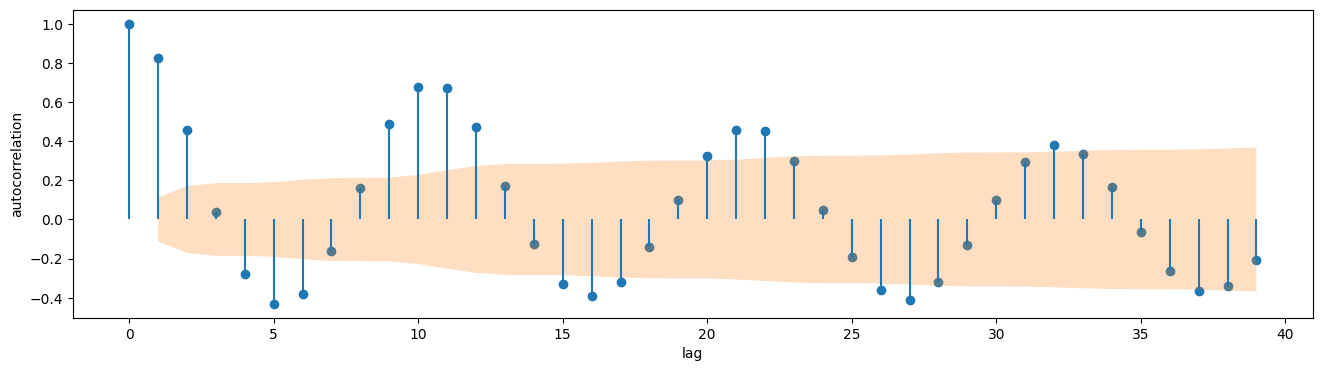

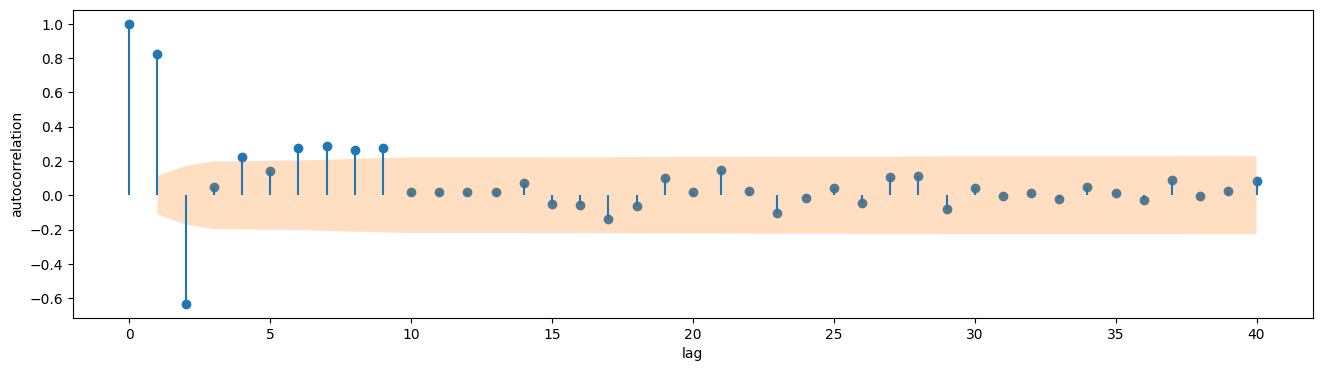

In [115]:
plot_acf(x)
plot_pacf(x)

Observamos que la función de autocorrelación (ACF) claramente disminuye y que la función de autocorrelación parcial (PACF) disminuye gradualmente, pero parece tener un corte notable en el rezago 3. Basándonos en esto, vamos a elegir un modelo ARIMA con q = 1, d = 0 y p = 3, y compararemos el modelo con la implementación de ARIMA de statsmodels.

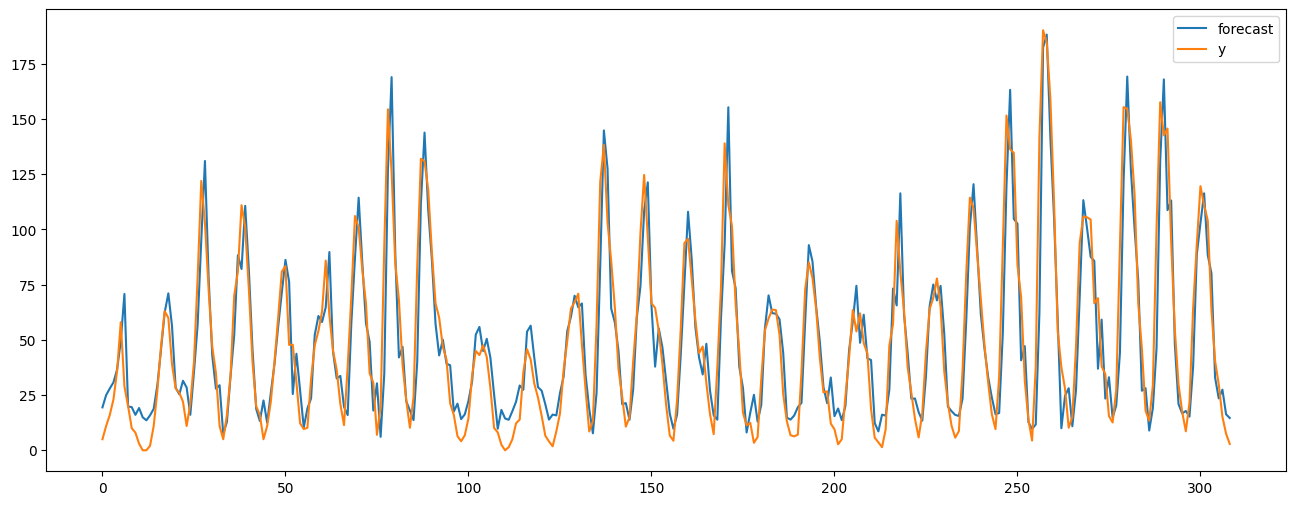

In [116]:
q = 1
d = 0
p = 3

m = ARIMA(q, d, p)
pred = m.fit_predict(x)

plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
ax.plot(pred, label='forecast')
ax.plot(x, label='y')
plt.legend()

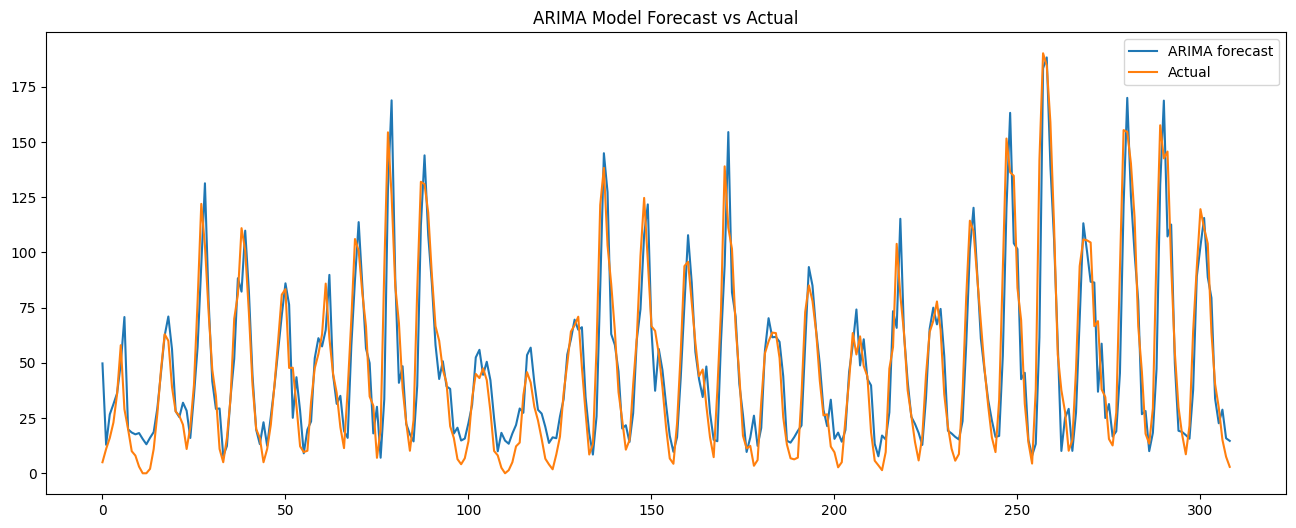

In [117]:
# Ajustar el modelo ARIMA con statsmodels
model = sm.tsa.ARIMA(x, order=(p, d, q))
results = model.fit()

# Predecir utilizando el modelo ajustado
forecast = results.predict()

# Visualizar los resultados
plt.figure(figsize=(16, 6))
plt.plot(forecast, label='ARIMA forecast')
plt.plot(x, label='Actual')
plt.title('ARIMA Model Forecast vs Actual')
plt.legend()
plt.show()

Como podemos ver en las gráficas anteriores, nuestro modelo ARIMA tiene casi la misma salida que la implementación de statsmodels. Sin embargo, existen algunas diferencias. Supongo que estas diferencias se deben al hecho de que statsmodels continúa actualizando los residuos, mientras que nosotros aceptamos los primeros residuos basados solo en el modelo AR inicial.

## Forecasting

Hay un método que no hemos discutido, que es el método de pronóstico (forecast). En este método intentamos predecir los valores futuros. Al pensar en cómo predecimos los valores futuros, también vemos las debilidades de este modelo. Esto se debe a que, mientras tengamos puntos de datos etiquetados, podemos calcular un término de error ϵt. Sin embargo, al hacer predicciones, no conocemos el punto de datos real Xt+k y, por lo tanto, no podemos calcular los residuos. Esto significa que después de realizar q predicciones (siendo q el orden del modelo MA), el modelo ARMA se convierte solo en un modelo AR, ya que E[ϵt+k] = 0 cancela los efectos de los términos MA. El modelo AR resultante describe cómo responde la serie temporal a un shock que desplaza Xt desde el valor medio de la serie.

A continuación, hacemos un pronóstico de 40 pasos temporales y podemos ver claramente la respuesta del modelo al último shock, disminuyendo hasta el valor medio de la serie. Esto también muestra el caso de uso de este tipo de modelo. Debería utilizarse para predicciones a corto plazo. Para predicciones a largo plazo, su salida es simplemente igual al valor medio de la serie.

/var/folders/dt/cxyz36h16ydfv1yg6n6v5fqm0000gn/T/ipykernel_16089/2374176826.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[x.shape[0] + i] = super().predict(feat[None, :])


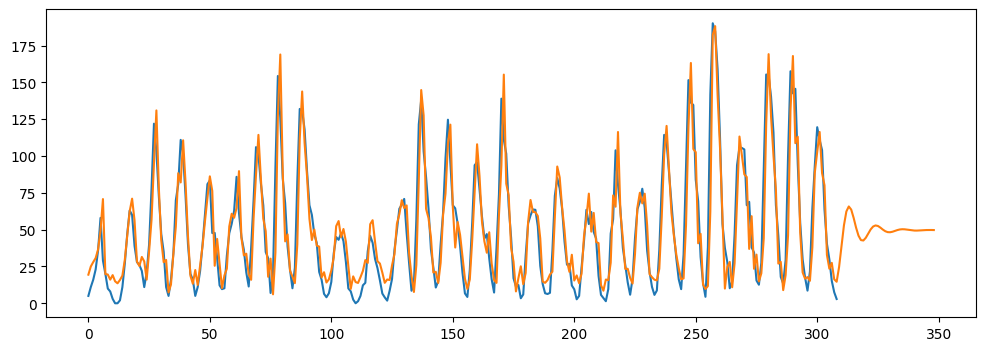

In [120]:
pred = m.forecast(x, 40)
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot(x)
ax.plot(pred)

Hemos discutido la definición de los modelos AR (Auto-Regresivo), MA (Media Móvil) y ARIMA (Auto-Regresivo Integrado de Media Móvil) en esta publicación, así como la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF). También hemos concluido que estos modelos solo pueden funcionar con datos estacionarios o datos con una tendencia, y que no son adecuados para pronósticos a largo plazo. Afortunadamente, existe una versión mejorada del modelo ARIMA llamada SARIMA (Seasonal ARIMA).

Estos modelos implementan un ARIMA en los parámetros p, d y q, además de un ARIMA adicional en los parámetros P, D y Q. El modelo adicional opera en la misma serie temporal, pero con un rezago estacional. Por ejemplo, un rezago estacional de 4 se vería así:

![Texto Alternativo](../../../Image/S.png)

Con esta extensión, el modelo también es más adecuado para pronósticos a largo plazo.